In [1]:
!module load pytorch-gpu/py3/1.10.0
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-e23d5a93-c07d-1333-8ffd-028fc6030154)


In [2]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
import itertools
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import random

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [191]:
# Hyperparameters

length = 12
batch_size = 8
epochs = 1
test_length = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [155]:
# dataset qui contient les donnees, ie la fonction de courant barotrope
# chemin sur jean-zay : /gpfswork/rech/omr/romr004/MLspinup/IPSLCM6ALR/
MSFTdataset = xr.open_dataset('/gpfswork/idris/sos/ssos025/HRMES/MLspinup/IPSLCM6ALR/msftbarot_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_185001-234912.nc',decode_times=False)
MSFTdataset

<xarray.Dataset>
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 ...
    nav_lon         (y, x) float32 ...
  * time            (time) float64 15.5 45.0 74.5 ... 1.826e+05 1.826e+05
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 ...
    bounds_nav_lat  (y, x, nvertex) float32 ...
    area            (y, x) float32 ...
    time_bounds     (time, axis_nbounds) float64 ...
    msftbarot       (time, y, x) float32 ...
Attributes: (12/51)
    name:                   /ccc/work/cont003/dsm/p86maf/IGCM_OUT/IPSLCM6/PRO...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-04-27T15:00:09Z
    tracking_id:            hdl:21.14100/17e4ba33-4948-4a89-b737-937464656d8d
    description:            DECK: control
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    ...                     ...
    variant_label:          r1i1p1f1
    EXPID:                  piControl
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    dr2xml_md5sum:          00e1a4f623b35a33620b9828c66bd1c8
    model_version:          6.1.2
    history:                Tue Jul 10 16:42:45 2018: ncatted -O -a coordinat...

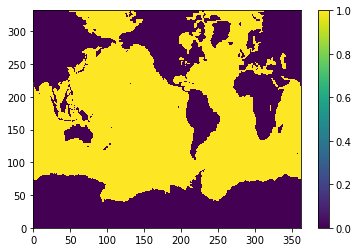

In [156]:
# dataset qui contient les informations "fixed in time" comme le masque terre / mer et la bathymetrie
MASKdataset = xr.open_dataset('/gpfswork/idris/sos/ssos025/HRMES/MLspinup/INPUTS/eORCA1.2_mesh_mask.nc',decode_times=False)
MASKdataset
mask = MASKdataset.tmask[0,0,:,:]
plt.pcolor(mask) ; plt.colorbar() 

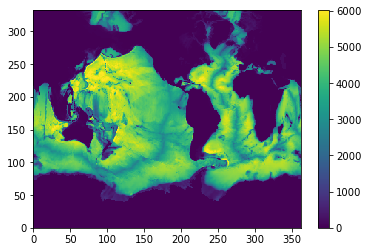

In [124]:
bathy = np.sum(MASKdataset.e3t_0[0,:,:,:]*MASKdataset.tmask[0,:,:],axis=0)
plt.pcolor(bathy)
plt.colorbar()

In [125]:
MSFTdataset.msftbarot.shape

(6000, 332, 362)

In [126]:
def get_ssca(dataset):
    dataset = np.array(dataset)
    x, y = dataset.shape[1:3]
    nbyears = dataset.shape[0] // 12
    arr = np.reshape(dataset, (nbyears, 12, x, y))
    arr = np.mean(arr, axis=0)
    arr = np.tile(arr, (nbyears, 1, 1, 1))
    arr = np.reshape(arr, (12 * nbyears, x, y))
    return dataset - arr

ssca = get_ssca(MSFTdataset.msftbarot)

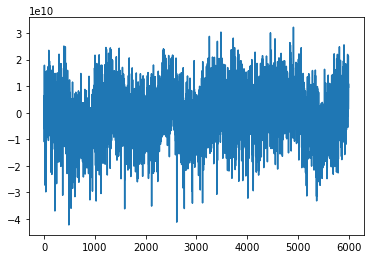

In [127]:
plt.plot(ssca[:, 110, 110])

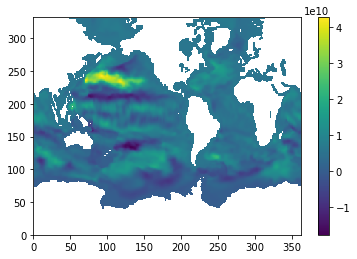

In [10]:
plt.pcolor(ssca[458])
plt.colorbar()

In [11]:
mask == 1.0

<xarray.DataArray 'tmask' (y: 332, x: 362)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: y, x

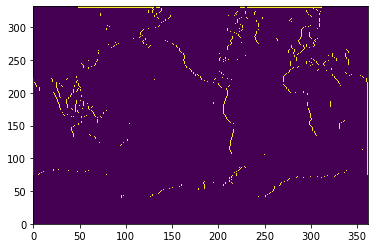

In [12]:
plt.pcolor(np.logical_and(mask == 1.0, ~np.isfinite(ssca[0])))

In [13]:
bool_mask = torch.tensor(np.asarray(np.isfinite(ssca[0])), dtype=bool).to(device=device)
mask = bool_mask.to(device=device, dtype=int)


In [51]:
ssca_tensor = torch.from_numpy(ssca)

In [52]:
ssca_tensor.shape

torch.Size([6000, 332, 362])

/tmp/ipykernel_1916259/299924065.py:2: RuntimeWarning: Mean of empty slice
  m = torch.from_numpy(np.nanmean(unfolded, axis=1, keepdims=True).reshape(1, 332, 362))
/linkhome/idris/genidr/ssos025/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


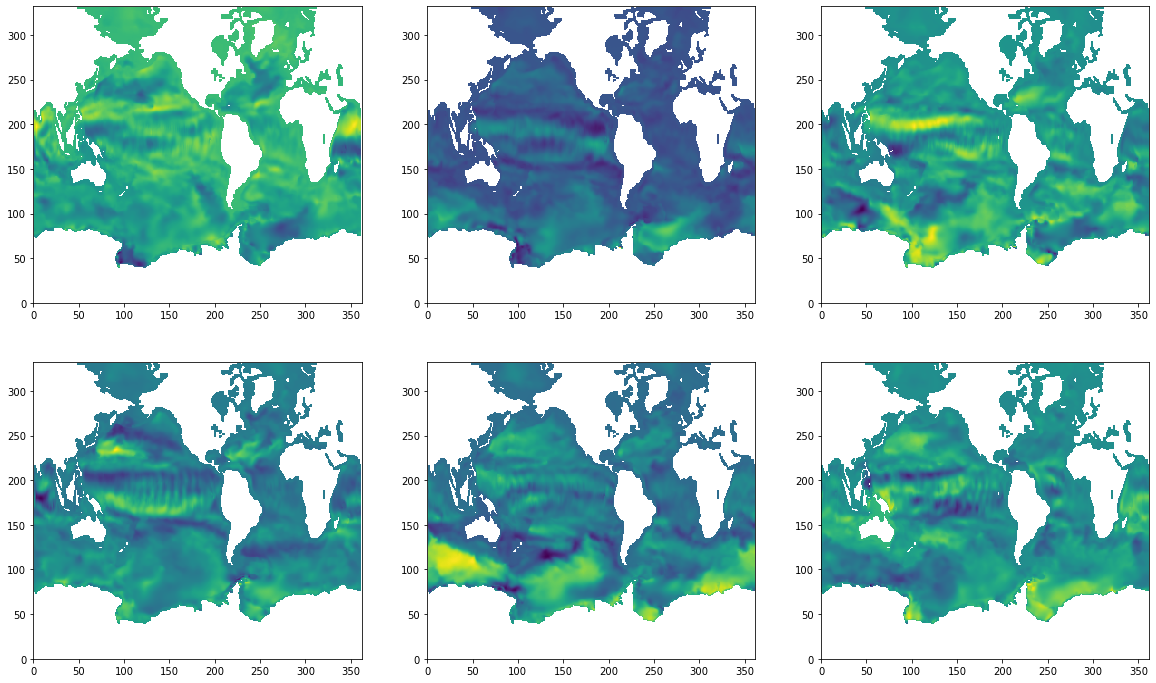

In [53]:
unfolded = torch.nn.Unfold(kernel_size=(3, 3), stride=1, padding=1, dilation=1)(ssca_tensor.unsqueeze(0)).numpy()
m = torch.from_numpy(np.nanmean(unfolded, axis=1, keepdims=True).reshape(1, 332, 362))
std = torch.from_numpy(np.nanstd(unfolded, axis=1, keepdims=True).reshape(1, 332, 362))
norm_ssca = (ssca_tensor - m) / (2.0 * std)

fig = plt.figure(figsize=(20,12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.pcolor(norm_ssca[i * 1000])

/tmp/ipykernel_1916259/2122164652.py:7: RuntimeWarning: Mean of empty slice
  norm_ssca = (ssca - np.nanmean(ssca, axis=0, keepdims=True)) / np.nanstd(ssca, axis=0, keepdims=True) / 2.0
/linkhome/idris/genidr/ssos025/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


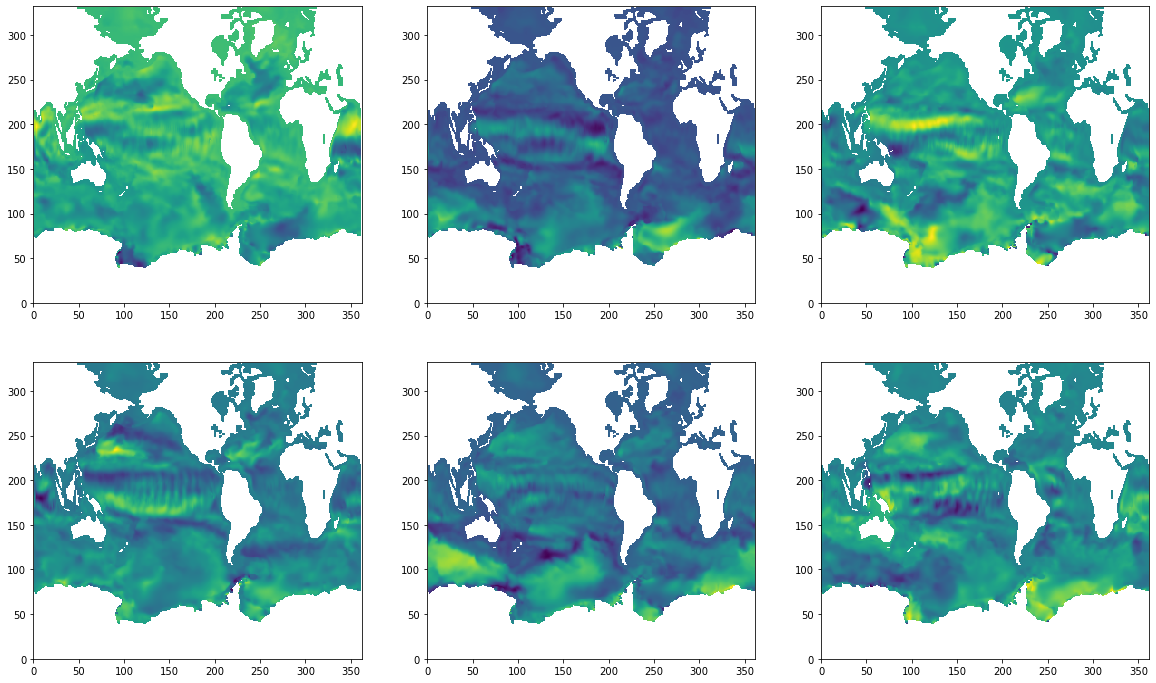

In [14]:
%matplotlib inline
"""
M = np.nanmax(ssca, axis=0, keepdims=True)
m = np.nanmin(ssca, axis=0, keepdims=True)
norm_ssca = (ssca - m) / (M - m)
"""
norm_ssca = (ssca - np.nanmean(ssca, axis=0, keepdims=True)) / np.nanstd(ssca, axis=0, keepdims=True) / 2.0

fig = plt.figure(figsize=(20,12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.pcolor(norm_ssca[i * 1000])

In [54]:
maps = norm_ssca if isinstance(norm_ssca, torch.Tensor) else torch.from_numpy(norm_ssca)

In [192]:
data = []
for i in tqdm(range(maps.shape[0] - length)):
    data.append(torch.arange(i, i + length + 1))
data = torch.stack(data, axis=0)

  0%|          | 0/5988 [00:00<?, ?it/s]

In [193]:
torch.allclose(maps[data[0]][0], maps[0], equal_nan=True)

True

In [194]:
class HRMESDataset(Dataset):

    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return self.indices.shape[0]

    def __getitem__(self, idx):
        idx = self.indices[idx]
        return maps[idx[:-1]], maps[idx[-1]]

In [195]:
train_ds = HRMESDataset(data[:5000])
test_ds = HRMESDataset(data[5000:])
print(len(train_ds), len(test_ds))
print(train_ds[0][0].shape, train_ds[0][1].shape)

5000 988
torch.Size([12, 332, 362]) torch.Size([332, 362])


In [196]:
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, num_workers=4, prefetch_factor=2)

In [218]:
class Pad(nn.Module):

    def __init__(self, offset=0):
        super(Pad, self).__init__()
        self.offset = offset

    def forward(self, x, offset=None):
        # Crop if offset is defined
        if offset is None:
            offset = self.offset
        if offset != 0:
            x = x[..., offset:-offset, offset:-offset]

        # Left-right padding
        x = torch.cat([
            x[..., -1, None],
            x,
            x[..., 0, None]
        ], axis=-1)

        # Top-bottom padding
        x = torch.cat([
            torch.zeros(list(x.shape[:-2]) + [1, x.shape[-1]] , device=x.device), # bottom padding
            x, 
            x[..., -1, None, :].flip(dims=(-1,)) # top padding
        ], axis=-2)
        
        return x

class Conv(nn.Module):

    def __init__(self, inp, out, mask):
        super(Conv, self).__init__()
        #self.mask = mask[None, None, ...]
        self.pad = Pad(offset=0)
        self.conv = nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=0, bias=True)
        self.relu = nn.SELU()

    def forward(self, x):
        x = self.pad(x)
        x = self.relu(self.conv(x))
        #x = x * self.mask
        return x

class HRMESModel(nn.Module):

    def __init__(self, mask):
        super(HRMESModel, self).__init__()
        self.mask = mask
        self.layers = nn.Sequential(
            Pad(offset=1),
            Conv(length, 32, mask=mask),
            Conv(32, 64, mask=mask),
            Conv(64, 128, mask=mask),
            Conv(128, 64, mask=mask),
            Conv(64, 32, mask=mask),
            Conv(32, 1, mask=mask)
            #nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = torch.nan_to_num(x)
        x = self.layers(x)
        x = x.squeeze(dim=1)
        return x

In [219]:
def define_model_optimizer_criterion():
    model = HRMESModel(mask)
    model = model.to(device=device)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(f"Model has {params} parameters")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
    return model, criterion, optimizer

def compute_loss(criterion, output, target):
    target = Pad.forward(..., target, offset=1)
    return criterion(
        torch.masked_select(output, bool_mask),
        torch.masked_select(target, bool_mask)
    )

model, criterion, optimizer = define_model_optimizer_criterion()

Model has 188385 parameters


Epoch  1


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Loss:  0.17222239743471146


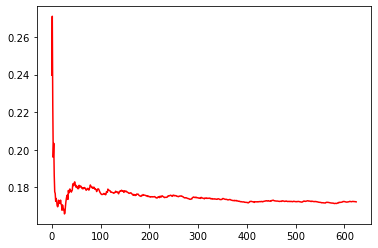

In [220]:
losses = []
test_losses = []

for epoch in range(epochs):
    print("Epoch ", epoch + 1)
    epoch_loss = 0.0
    pbar = tqdm(train_dataloader)
    for i, (x, y) in enumerate(pbar, start=1):
        x, y = x.to(device), y.to(device)
        output = model(x)

        optimizer.zero_grad()
        loss = compute_loss(criterion, output, y)
        loss.backward()
        optimizer.step()

        loss = loss.item()
        epoch_loss += loss
        losses.append(epoch_loss / i)
        pbar.set_description(f"Loss: {epoch_loss / i:.3f}")
        del x, y
    
    pbar = tqdm(test_dataloader)
    test_loss = 0.0
    
    for i, (x, y) in enumerate(pbar, start=1):
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            output = model(x)
            output = torch.masked_select(output, bool_mask)
            y = torch.masked_select(y, bool_mask)
            loss = criterion(output, y)
            loss = loss.item()
            test_loss += loss
            pbar.set_description(f"Test loss: {test_loss / i:.3f}")
            test_losses.append(loss)
    test_loss /= len(test_dataloader)
    epoch_loss /= len(train_dataloader)
    print("Loss: ", epoch_loss)

plt.figure()
plt.plot(losses, "r-", label="Training loss")
plt.show()

Chosen idx: 328
Mean of ground truth: -0.544 ; Std of ground truth: 0.343
Mean of predicted map: -0.139 ; Std of predicted map: 0.179


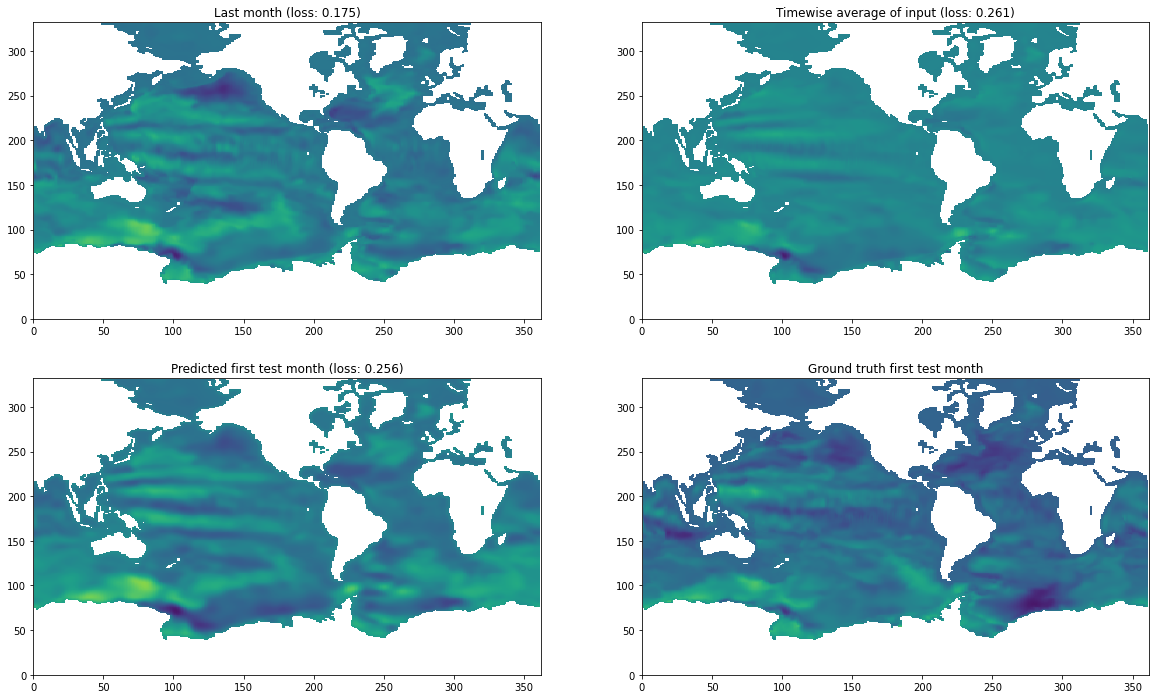

In [229]:
def test_sample(model, test_ds, idx=None):
    if idx is None:
        idx = random.randrange(len(test_ds))
    print("Chosen idx:", idx)
    x, y = test_ds[idx]
    x, y = x.to(device), y.to(device)
    
    last_month = x[-1]
    average = x.mean(0)
    output = model(x[None])[0]

    loss_last_month = compute_loss(criterion, last_month, y).item()
    loss_average = compute_loss(criterion, average, y).item()
    loss_prediction = compute_loss(criterion, output, y).item()
    
    output = output.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    output[np.isnan(y)] = np.nan
    expectedmean, expectedstd = np.nanmean(y), np.nanstd(y)
    obtainedmean, obtainedstd = np.nanmean(output), np.nanstd(output)
    print(f"Mean of ground truth: {expectedmean:.3f} ; Std of ground truth: {expectedstd:.3f}")
    print(f"Mean of predicted map: {obtainedmean:.3f} ; Std of predicted map: {obtainedstd:.3f}")
    
    # Display
    fig = plt.figure(figsize=(20, 12))
    plt.subplot(2, 2, 1)
    plt.pcolor(last_month.cpu().numpy(), vmin=-2, vmax=2)
    plt.title(f"Last month (loss: {loss_last_month:.3f})")
    plt.subplot(2, 2, 2)
    plt.pcolor(average.cpu().numpy(), vmin=-2, vmax=2)
    plt.title(f"Timewise average of input (loss: {loss_average:.3f})")
    plt.subplot(2, 2, 3)
    plt.pcolor(output, vmin=-1, vmax=1)
    plt.title(f"Predicted first test month (loss: {loss_prediction:.3f})")
    plt.subplot(2, 2, 4)
    plt.pcolor(y, vmin=-2, vmax=2)
    plt.title("Ground truth first test month")

test_sample(model, test_ds)

Chosen idx: 100
Mean of ground truth: 0.327 ; Std of ground truth: 0.320
Mean of predicted map: 0.128 ; Std of predicted map: 0.173


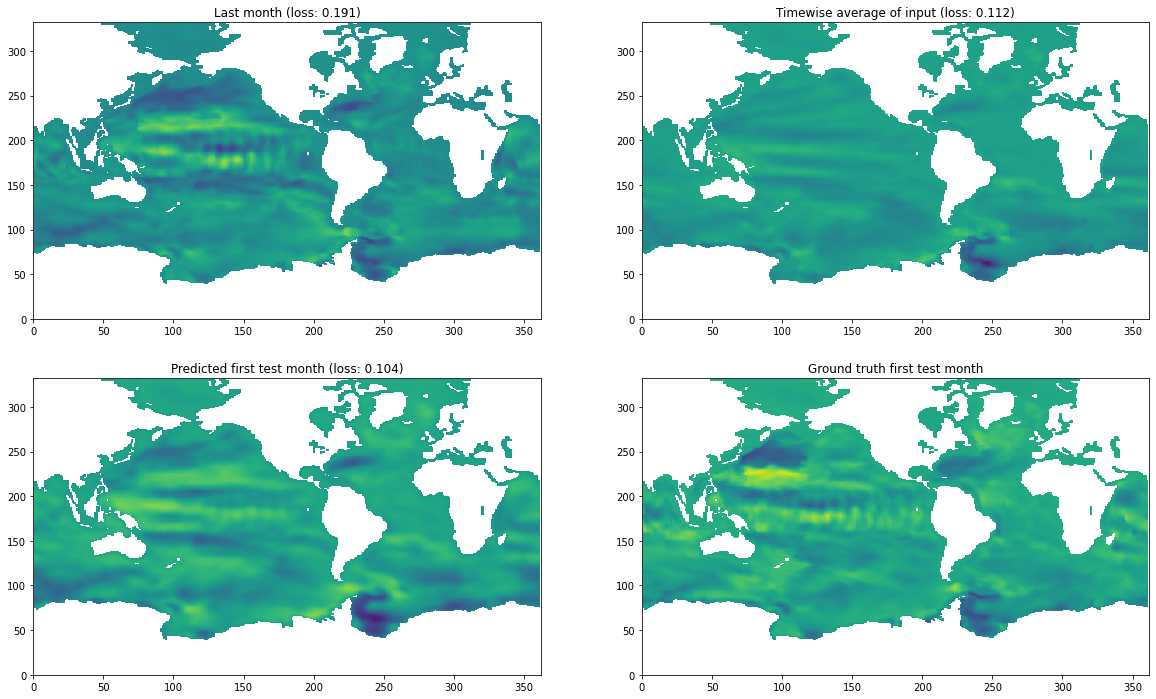

In [230]:
test_sample(model, test_ds, 100)

Chosen idx: 208
Mean of ground truth: -0.022 ; Std of ground truth: 0.268
Mean of predicted map: -0.049 ; Std of predicted map: 0.152


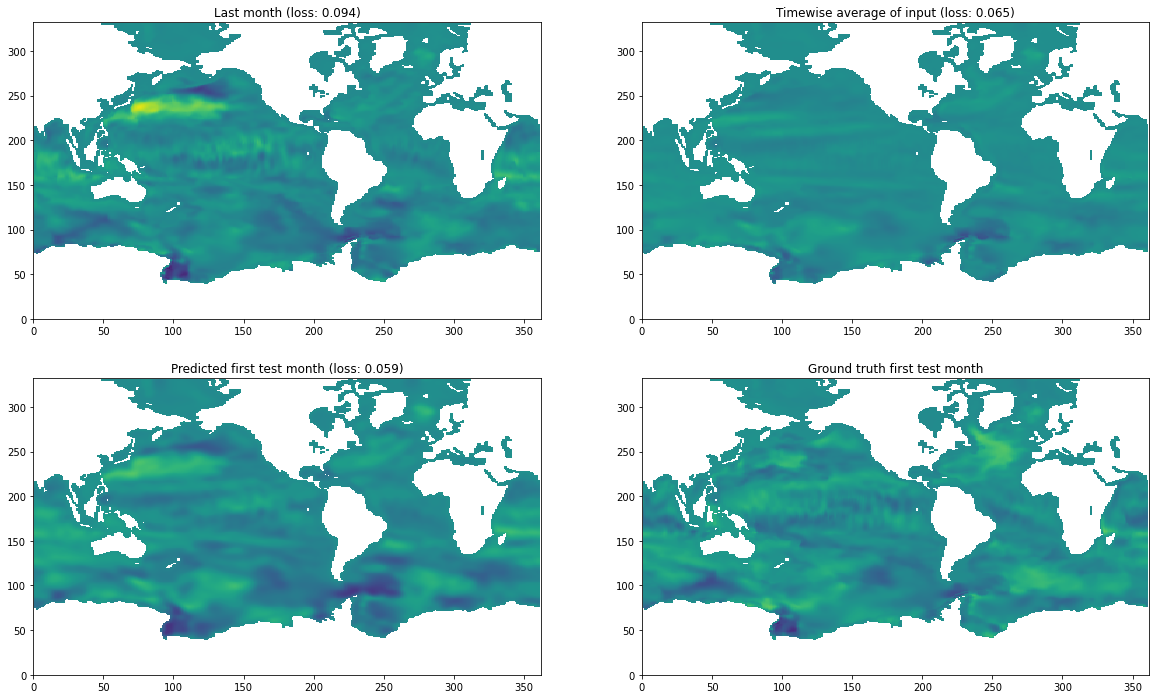

In [231]:
test_sample(model, test_ds)

  0%|          | 0/98 [00:00<?, ?it/s]

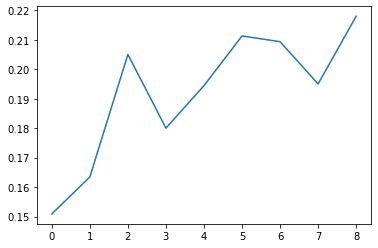

In [232]:
def quantify_quality_one_signal(model, test_ds, first_index, last_index):
    losses = []
    x, y = test_ds[first_index]
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        for i in range(first_index + 1, last_index):
            out = model(x[None])
            output = torch.masked_select(out, bool_mask)
            y = torch.masked_select(y, bool_mask)
            loss = criterion(output, y)
            losses.append(loss.item())
            x = torch.cat([x[1:, :, :], out], dim=0)
            y = test_ds[i][1].to(device)

    return losses

def quantify_quality_average(model, test_ds):
    indices = [(test_length * i, test_length * (i+1)) for i in range(len(test_ds) // test_length)]
    losses = None
    for first_idx, last_idx in tqdm(indices):
        loss = quantify_quality_one_signal(model, test_ds, first_idx, last_idx)
        if losses is None:
            losses = np.array(loss)
        else:
            losses += np.array(loss)
    return losses / len(indices)
        
losses = quantify_quality_average(model, test_ds)
plt.plot(losses)